In [1]:
#Importing the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import statsmodels.api as sms
from datetime import datetime 
import warnings
from prophet import Prophet
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Importing the files and storing them as data frames
df_train = pd.read_csv("train.csv")
df_features = pd.read_csv("features.csv")
df_stores = pd.read_csv("stores.csv")

In [3]:
#Statistical analysis of the train data
df_train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [4]:
#Removing the Weekly_Sales which is less than zero
df_train = df_train[df_train['Weekly_Sales']>0]
df_train.describe()

,Store,Dept,Weekly_Sales
count,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591
std,12.787236,30.508819,22729.492116
min,1.000000,1.000000,0.010000
25%,11.000000,18.000000,2120.130000
50%,22.000000,37.000000,7661.700000
75%,33.000000,74.000000,20271.265000
max,45.000000,99.000000,693099.360000


In [5]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


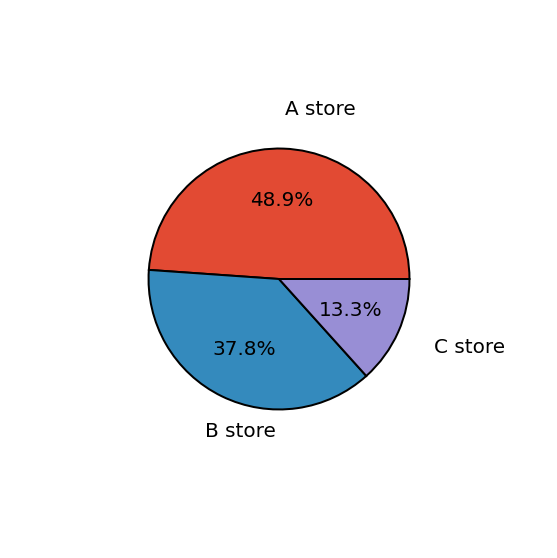

In [7]:
#Plotting a Pie chart showing the percentage distribution of each type of Store
sorted_type = df_stores.groupby('Type')
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion
fig, axes = plt.subplots(1,1, figsize=(10,10))
w_prop={'edgecolor':'black',
      'linewidth':2}
t_prop = {'fontsize':20}
axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.3,
        wedgeprops=w_prop,
        textprops=t_prop,
        radius=0.6,
        center=(0.5,0.5))
plt.show()

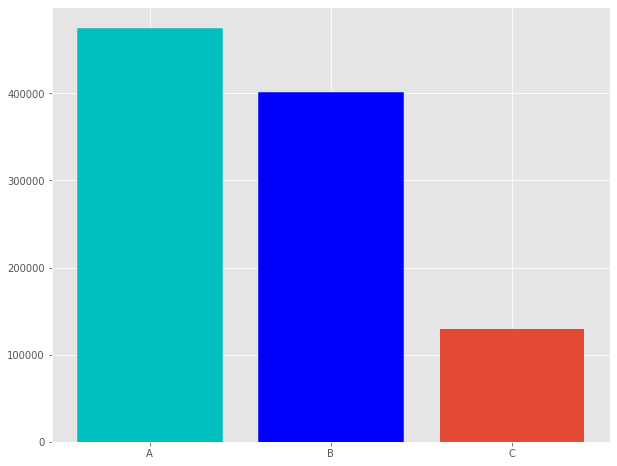

In [8]:
#Plotting a bar chart showing the aggregated sum of weekly sales based on store type
data2 = pd.concat([df_stores['Type'], df_train['Weekly_Sales']], axis=1)
data_type = data2.groupby(by='Type').agg({'Weekly_Sales':'sum'})
plt.figure(figsize=(10,8))
barlist = plt.bar(data_type.index, data_type['Weekly_Sales'])
barlist[0].set_color('c')
barlist[1].set_color('b')
plt.show()

array([<AxesSubplot:title={'center':'Weekly_Sales'}, xlabel='[Type]'>],
      dtype=object)

<Figure size 1080x720 with 0 Axes>

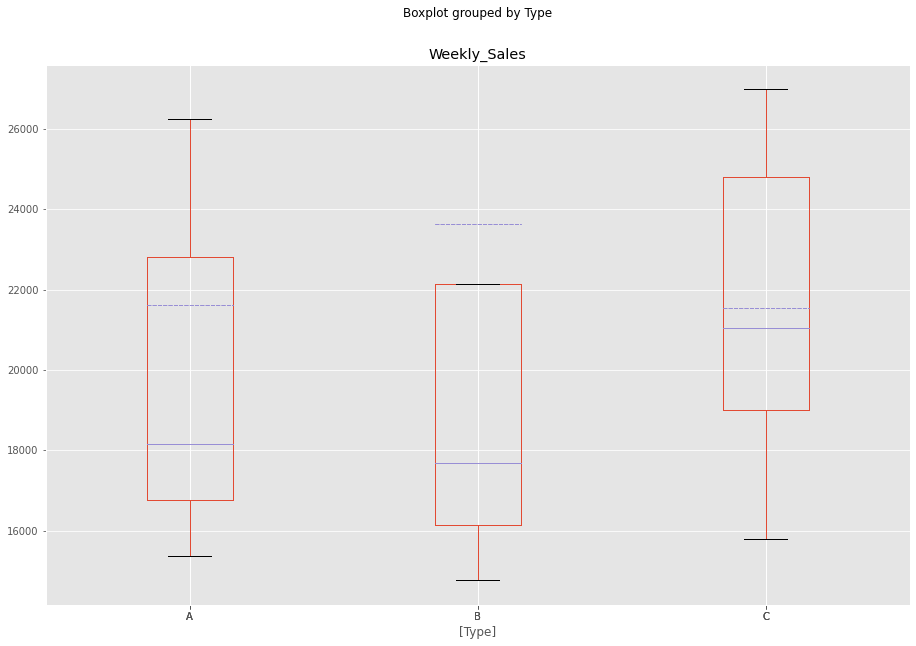

In [9]:
#Plotting a Box Plot for the weekly sales for each type of store
figure(figsize=(15,10))
a1=data2[['Weekly_Sales','Type']]
ax = a1.boxplot(by='Type', meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=False, figsize=(15,10), return_type='axes')
a2=data2[['Weekly_Sales','Type']]
a2.boxplot(by='Type', meanline=True, showmeans=True, showcaps=True, 
           showbox=True, showfliers=False, ax=ax)
a2=data2[['Weekly_Sales','Type']]
a2.boxplot(by='Type', meanline=True, showmeans=True, showcaps=True, 
           showbox=True, showfliers=False, ax=ax)

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

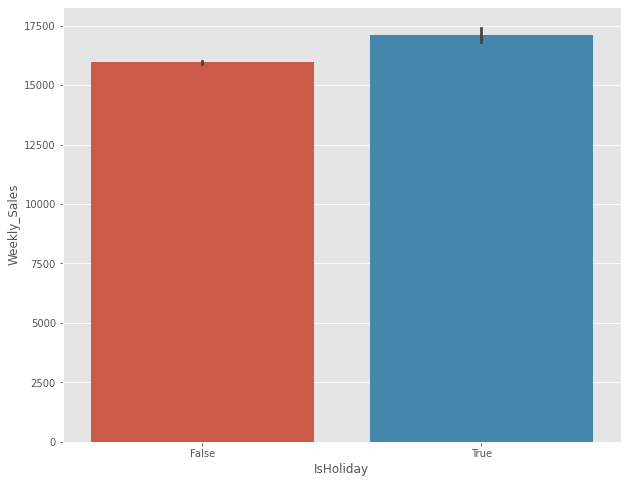

In [10]:
#Plotting a bar plot showing the sales when there is a holiday vs when it is not a holiday
figure(figsize=(10,8))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df_train)

In [11]:
#Joining features and stores with the main dataframe 
df_st_fe = df_train.merge(df_features, on = ['Store','Date'], how = 'inner').merge(df_stores,on=['Store'],how='inner')

In [12]:
#Removing duplicate column and renaming to maintain consistency
df_st_fe = df_st_fe.drop('IsHoliday_y',axis=1)
df_st_fe.rename(columns={'IsHoliday_x':'IsHoliday'}, inplace=True)

In [13]:
#Filling the values of NA for Markdowns with 0
df_st_fe.fillna(0, inplace=True)
df_st_fe.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [14]:
#Setting the date to a datetime object, indexing through it, resampling on start of the month and changing column names
df_st_fe['Date'] = pd.to_datetime(df_st_fe['Date'], format='%Y-%m-%d')
df_st_fe.set_index('Date', inplace=True)
df_st_fe = df_st_fe.resample('MS').mean()
df_st_fe.rename(columns={'Weekly_Sales':'Monthly_Sales'}, inplace=True)

In [15]:
#Defining a function to plot the scatter plot, Monthly_sales vs Specific Feature 
def scatter_pl(df_st_fe, column):
    plt.figure()
    plt.scatter(df_st_fe[column] , df_st_fe['Monthly_Sales'])
    plt.ylabel('Monthly_Sales')
    plt.xlabel(column)

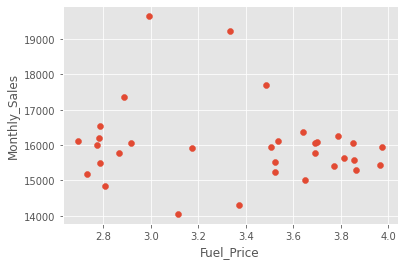

In [16]:
#Plotting a scatter plot for  Monthly_sales vs Fuel_Price
scatter_pl(df_st_fe, 'Fuel_Price')

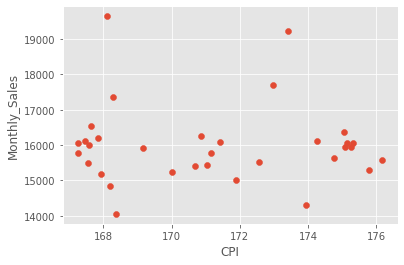

In [17]:
#Plotting a scatter plot for  Monthly_sales vs CPI
scatter_pl(df_st_fe, 'CPI') 

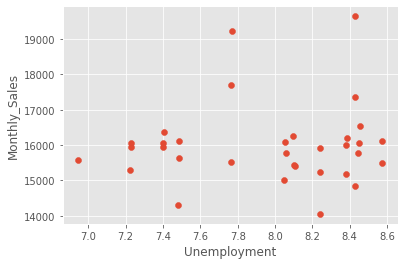

In [18]:
#Plotting a scatter plot for  Monthly_sales vs Unemployment
scatter_pl(df_st_fe, 'Unemployment')

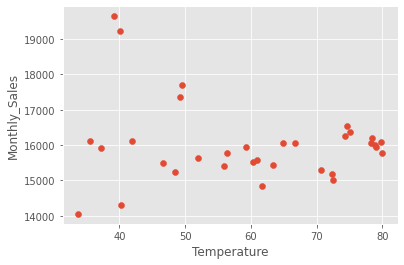

In [19]:
#Plotting a scatter plot for  Monthly_sales vs Temperature
scatter_pl(df_st_fe, 'Temperature')

In [20]:
#Splitting the data 80-20
train_df = df_st_fe[:int(0.8*(len(df_st_fe)))]
test_df = df_st_fe[int(0.8*(len(df_st_fe))):]
train = train_df['Monthly_Sales']
test = test_df['Monthly_Sales']

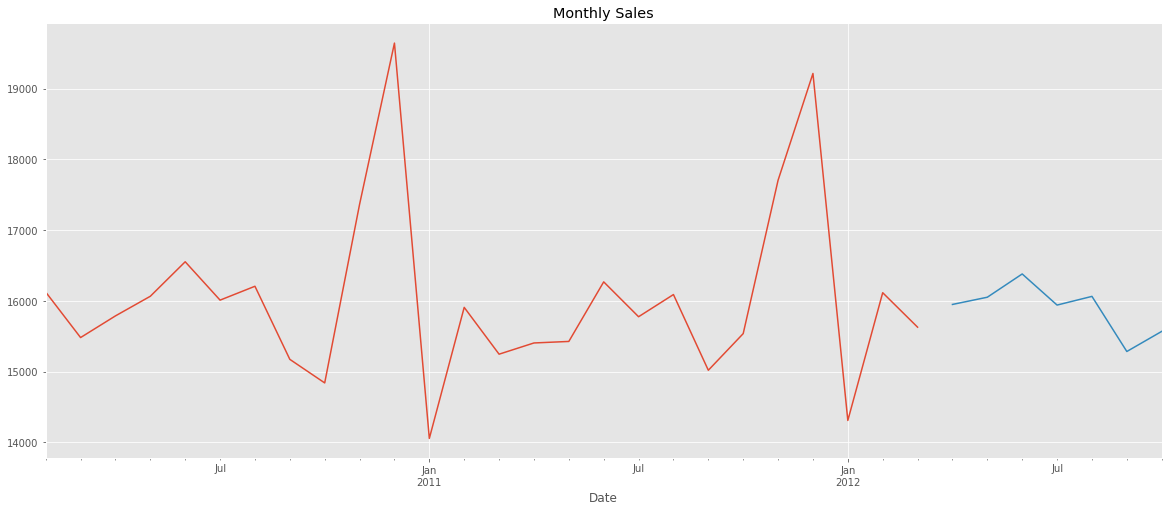

In [21]:
#Plotting test and train
plt.title("Monthly Sales")
train.plot(figsize=(20,8))
test.plot(figsize=(20,8))
plt.show()

In [22]:
#Function for implementing ADFuller Test
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [23]:
#Testing on Monthly Sales
from statsmodels.tsa.stattools import adfuller
adf_test(train)

ADF Statistics: -5.116882330046293
p- value: 1.2963600508551896e-05
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


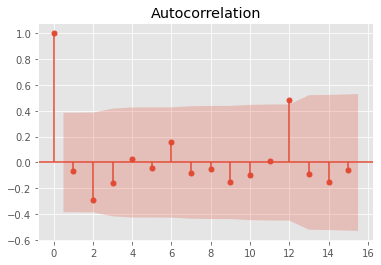

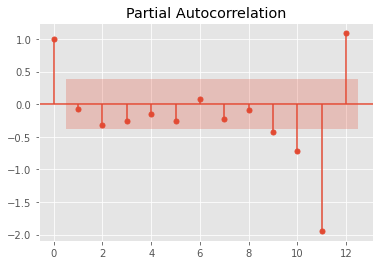

In [24]:
#Plotting ACF and PACF on Train data
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf = plot_acf(train)
pacf = plot_pacf(train,lags=12)

In [25]:
#Differencing to remove trend and seasonality and running ADFuller Test
train = train.to_frame()
train['Diff_1'] = train['Monthly_Sales'] - train['Monthly_Sales'].shift(1)
train['Diff_1_12'] = train['Diff_1'] - train['Diff_1'].shift(12)
adf_test(train['Diff_1_12'].dropna())

ADF Statistics: -3.8966111398262395
p- value: 0.002059929288817643
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


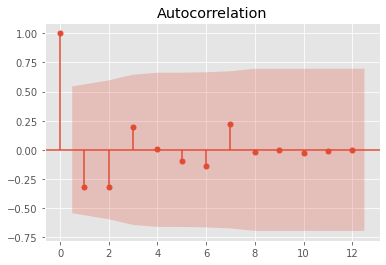

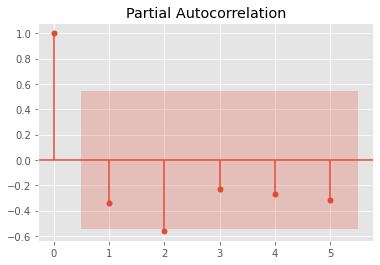

In [26]:
#Plotting ACF and PACF on the differenced column
acf = plot_acf(train['Diff_1_12'].dropna())
pacf = plot_pacf(train['Diff_1_12'].dropna(), lags=5)

In [27]:
#Autoarima for knowing the model with least AIC
from pmdarima import auto_arima
model_auto_arima = auto_arima(train['Diff_1_12'], trace=True, suppress_warnings=True,start_p=0, start_q=0, start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,m=12,stepwise=False, D=0,d=0, max_D=10,error_action='ignore',approximation = False)
model_auto_arima.fit(train['Diff_1_12'])

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=197.085, Time=0.57 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=192.060, Time=0.17 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=195.676, Time=0.29 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=198.130, Time=0.34 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=0

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

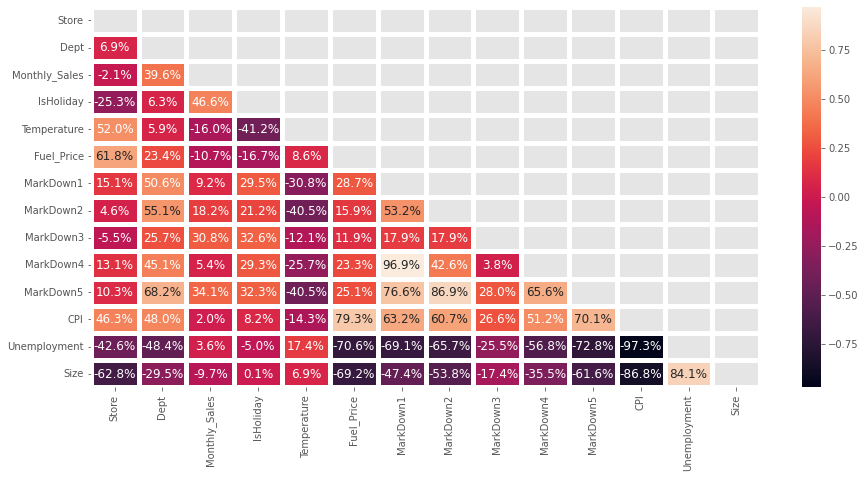

In [28]:
#Creating correlation matrix to identify additional/exogenous variables
corr = train_df.corr()
plt.figure(figsize=(15,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,linewidths=5,mask=mask,fmt = '.1%',annot_kws={"size": 12})
plt.show()

In [29]:
#Model fitting SARIMA(0,1,0)(1,1,1,12)
from statsmodels.tsa.statespace.sarimax import SARIMAX
train = train['Monthly_Sales']
model_SARIMA=SARIMAX(train,order=(0,1,0),seasonal_order=(1,1,1,12))

In [30]:
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Monthly_Sales   No. Observations:                   26
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -95.761
Date:                              Sun, 27 Mar 2022   AIC                            197.523
Time:                                      14:31:22   BIC                            199.218
Sample:                                  02-01-2010   HQIC                           197.175
                                       - 03-01-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4391      0.417      1.054      0.292      -0.377       1.255
ma.S.L12      -0.9988      0.595     -1.678      0.093      -2.166       0.168
sigma2      1.117e+05   5.36e-06   2.08e+10      0.000    1.12e+05    1.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.12   Prob(JB):                         0.87
Heteroskedasticity (H):               4.12   Skew:                             0.36
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.72e+26. Standard errors may be unstable.
"""

In [31]:
#Ljungbox test
from statsmodels.stats.diagnostic import acorr_ljungbox
sms.stats.acorr_ljungbox(model_SARIMA_fit.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,9.249803,0.681459


In [32]:
#Calculating MSE
from sklearn.metrics import mean_squared_error
forecast = model_SARIMA_fit.forecast(steps=len(test))
mse = mean_squared_error(test,forecast)

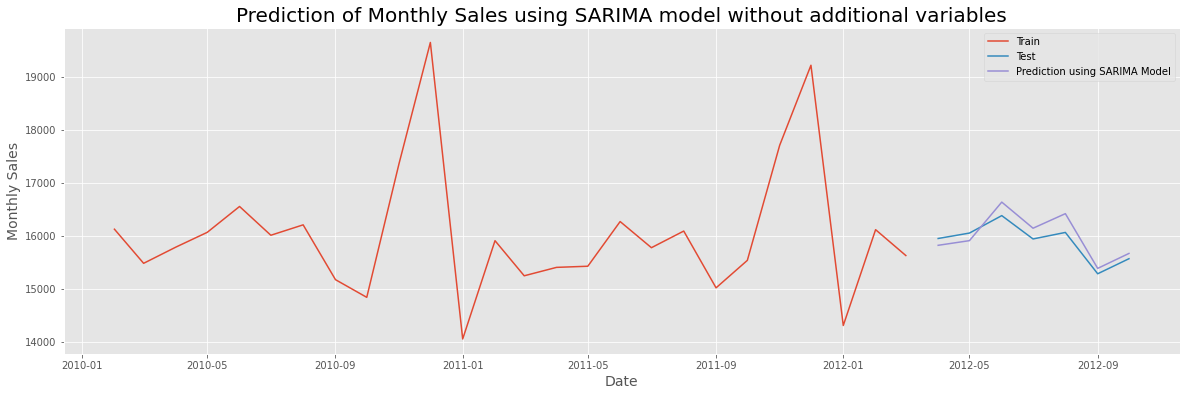

In [33]:
#Visualizing the forecast vs test values
forecast = forecast.to_frame()
plt.figure(figsize=(20,6))
plt.title('Prediction of Monthly Sales using SARIMA model without additional variables', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction using SARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.show()

In [34]:
#MSEP
print("The value of MSPE is: ", mse)

The value of MSPE is:  41176.254562791146


## Additional Variables

In [35]:
#Using Additional Variables as 'IsHoliday','MarkDown5','MarkDown3'
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA=SARIMAX(train,order=(0,1,0),seasonal_order=(1,1,1,12),exog = train_df[['IsHoliday','MarkDown5','MarkDown3']])

In [36]:
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Monthly_Sales   No. Observations:                   26
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -88.000
Date:                              Sun, 27 Mar 2022   AIC                            187.999
Time:                                      14:31:22   BIC                            191.389
Sample:                                  02-01-2010   HQIC                           187.303
                                       - 03-01-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IsHoliday   9025.1920   4026.787      2.241      0.025    1132.835    1.69e+04
MarkDown5     -0.1326      0.069     -1.926      0.054      -0.268       0.002
MarkDown3      0.0044      0.090      0.049      0.961      -0.171       0.180
ar.S.L12       0.0351      3.237      0.011      0.991      -6.310       6.381
ma.S.L12      -0.8957      3.325     -0.269      0.788      -7.413       5.622
sigma2      2.648e+04      1.720   1.54e+04      0.000    2.65e+04    2.65e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.50   Prob(JB):                         0.65
Heteroskedasticity (H):               0.20   Skew:                             0.51
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.16e+22. Standard errors may be unstable.
"""

In [37]:
sms.stats.acorr_ljungbox(model_SARIMA_fit.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,11.163105,0.514995


In [38]:
forecast = model_SARIMA_fit.forecast(steps=len(test),exog=test_df[['IsHoliday','MarkDown5','MarkDown3']])
mse = mean_squared_error(test,forecast)

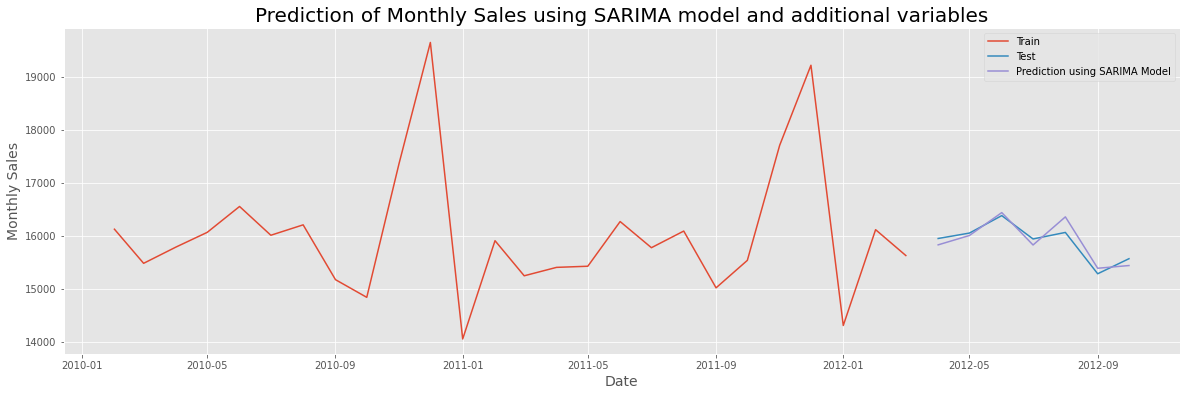

In [39]:
forecast = forecast.to_frame()
plt.figure(figsize=(20,6))
plt.title('Prediction of Monthly Sales using SARIMA model and additional variables', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction using SARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.show()

In [40]:
#MSPE
print("The value of MSPE with additional variables is: ", mse)

The value of MSPE with additional variables is:  20876.852594609518


## FB Prophet

In [41]:
#Renaming the column names to fit the architecture
train = train.to_frame()
train.reset_index(drop=False,inplace=True)
train.rename(columns={'Date':'ds', 'Monthly_Sales':'y'}, inplace = True)

In [42]:
#Model fitting using additive seasonality
m = Prophet(seasonality_mode = 'additive')
m.fit(train) 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


In [43]:
#Forecasting using FB Prophet and storing the outputs in a separate frame
future = m.make_future_dataframe(periods=7, freq='MS')
forecast = m.predict(future)
forecast_pred = forecast.tail(7)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']

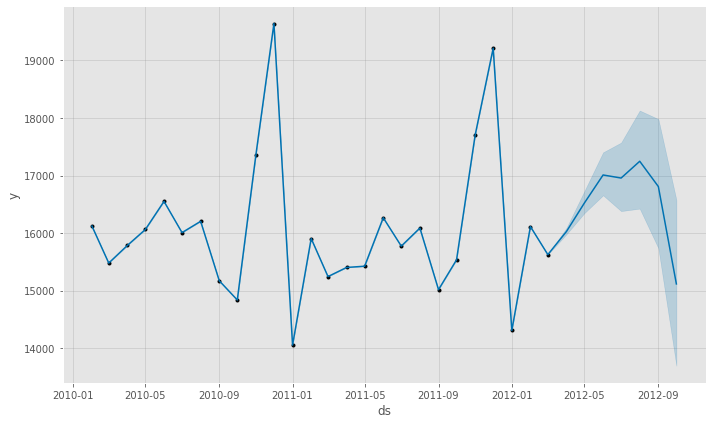

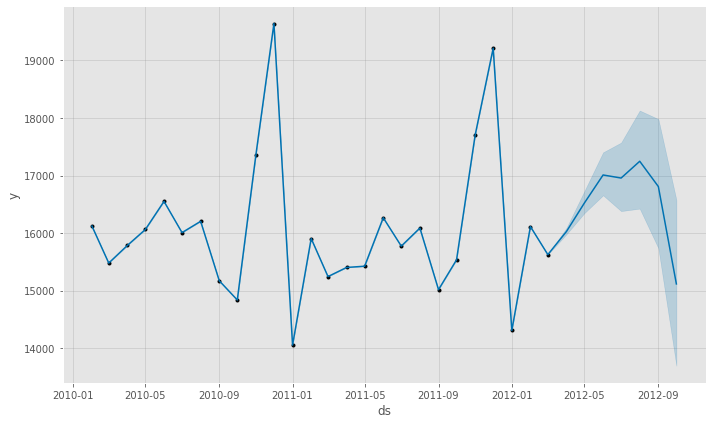

In [44]:
#Plotting
m.plot(forecast)

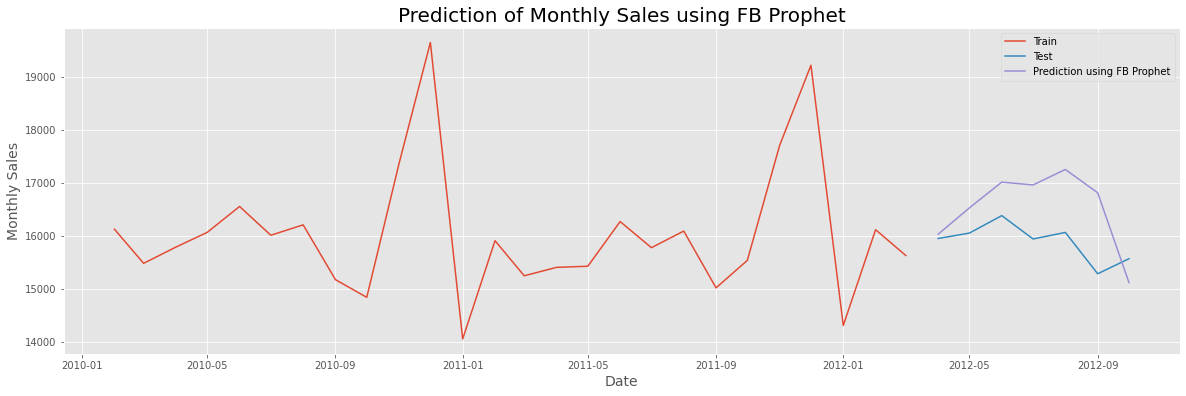

In [45]:
train = train_df['Monthly_Sales']
forecast_pred = forecast_pred.to_frame()
plt.figure(figsize=(20,6))
plt.title('Prediction of Monthly Sales using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_pred, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.show()

In [46]:
mse = mean_squared_error(test,forecast_pred)
print("The value of MSPE with FB Prophet is: ", mse)

The value of MSPE with FB Prophet is:  800964.3367355156
